# Master's thesis case study 2: Variable Covariates: Linear Predictor with additional target

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy
import torch
from adaptive_nof1 import *
from adaptive_nof1.policies import *
from adaptive_nof1.helpers import *
from adaptive_nof1.inference import *
from adaptive_nof1.metrics import *
from adaptive_nof1.inference import BayesianModel
from matplotlib import pyplot as plt
import seaborn

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Calculation example
df = pandas.DataFrame({"c": [ 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3] * 2, "k": [1, 2, 3] * 3 * 2})
df["a"] = [1.8] * 9 + [2.1] * 9
df["$\Delta_{i,j,k}$"] = numpy.exp(df["c"] * (df["k"] * df["a"]))
df["$\eta_{i,j,k}$"] = df["$\Delta_{i,j,k}$"] / df["k"]

df

,c,k,a,"$\Delta_{i,j,k}$","$\eta_{i,j,k}$"
0,0.1,1,1.8,1.197217,1.197217
1,0.1,2,1.8,1.433329,0.716665
2,0.1,3,1.8,1.716007,0.572002
3,0.2,1,1.8,1.433329,1.433329
4,0.2,2,1.8,2.054433,1.027217
5,0.2,3,1.8,2.944680,0.981560
6,0.3,1,1.8,1.716007,1.716007
7,0.3,2,1.8,2.944680,1.472340
8,0.3,3,1.8,5.053090,1.684363
9,0.1,1,2.1,1.233678,1.233678


In [4]:
with open('mt_resources/6-covariates/02-calculation-example.tex', 'w') as file:
    str = df.style.format(precision=2).hide(axis="index").to_latex()
    print(str)
    file.write(str)

\begin{tabular}{rrrrr}
c & k & a & $\Delta_{i,j,k}$ & $\eta_{i,j,k}$ \\
0.10 & 1 & 1.80 & 1.20 & 1.20 \\
0.10 & 2 & 1.80 & 1.43 & 0.72 \\
0.10 & 3 & 1.80 & 1.72 & 0.57 \\
0.20 & 1 & 1.80 & 1.43 & 1.43 \\
0.20 & 2 & 1.80 & 2.05 & 1.03 \\
0.20 & 3 & 1.80 & 2.94 & 0.98 \\
0.30 & 1 & 1.80 & 1.72 & 1.72 \\
0.30 & 2 & 1.80 & 2.94 & 1.47 \\
0.30 & 3 & 1.80 & 5.05 & 1.68 \\
0.10 & 1 & 2.10 & 1.23 & 1.23 \\
0.10 & 2 & 2.10 & 1.52 & 0.76 \\
0.10 & 3 & 2.10 & 1.88 & 0.63 \\
0.20 & 1 & 2.10 & 1.52 & 1.52 \\
0.20 & 2 & 2.10 & 2.32 & 1.16 \\
0.20 & 3 & 2.10 & 3.53 & 1.18 \\
0.30 & 1 & 2.10 & 1.88 & 1.88 \\
0.30 & 2 & 2.10 & 3.53 & 1.76 \\
0.30 & 3 & 2.10 & 6.62 & 2.21 \\
\end{tabular}



## Linear Predictor with additional target (reducing dose)

In [5]:
length = 20
number_of_patients = 10

In [5]:
length = 3
number_of_patients = 1

In [6]:
# Data Generating Model
# In this case study, we assume a log-linear regression
# log(Outcome) = df["c"] * (df["k"] / df["a"])
# (Think of c as pain and x as the pill, and a as how effective the pill is)
class LogModel(Model):
    def __init__(self, patient_id, number_of_interventions):
        self.rng = numpy.random.default_rng(patient_id)
        self.a = self.rng.uniform(1.8, 2.2)
        self.patient_id = patient_id
        self.number_of_interventions = number_of_interventions

    @property
    def additional_config(self):
        return {}

    @property
    def number_of_interventions(self):
        return self._number_of_interventions

    @number_of_interventions.setter
    def number_of_interventions(self, value):
        self._number_of_interventions = value
 
    def generate_context(self, history):
        return { "c": abs(self.rng.normal(0, 0.2)) }

    def observe_outcome(self, intervention, context):
        intervention_index = intervention["treatment"]
        dose = intervention_index + 1

        reduced_pain = self.rng.normal( numpy.exp(context["c"] * (dose * self.a)), 1)
        reduction_per_dose = reduced_pain / dose
        
        return {"outcome": reduced_pain, "reduction_per_dose": reduction_per_dose, "dose": dose}

    def __str__(self):
        return f"LogLinearModel"

data_generating_model = lambda patient_id: LogModel(patient_id, 3)

In [39]:
# Inference Model
class LogInference(BayesianModel):
    def __init__(self, **kwargs):
        self.outcome_name = "outcome"
        self.number_of_treatments = None
        super().__init__(**kwargs)
    
    def __str__(self):
        return f"LogInference"
    
    def update_posterior(self, history, number_of_treatments):
        self.number_of_treatments = number_of_treatments
        df = history.to_df()
        if len(df) == 0:
            df["c"] = []
            df["outcome"] = []

        self.model = pymc.Model()
        with self.model:
            dose = pymc.MutableData("dose", pymc.floatX(df[self.treatment_name] + 1), dims="observation")
            a = pymc.Uniform("a", lower=1, upper=3)
            c = pymc.MutableData("c", pymc.floatX(df["c"]), dims="observation")
            exponent = pymc.Deterministic("exponent", c * dose * a, dims="observation")
            outcome = pymc.Normal(
                "outcome", mu=pymc.math.exp(exponent), observed=df["outcome"], sigma=1, dims="observation",
            )
            reduction_per_dose = pymc.Deterministic("reduction_per_dose", outcome / dose, dims="observation")
            self.trace = pymc.sample(2000, progressbar=False)

    def approximate_max_probabilities(self, number_of_treatments, context):
        assert (
            self.trace is not None
        ), "You called `approximate_max_probabilites` without updating the posterior"
        with self.model:
            pymc.set_data(
                {
                    "dose": pymc.floatX(numpy.array(range(number_of_treatments)) + 1),
                    "c": pymc.floatX([context["c"]] * number_of_treatments),
                },
            )
            self.trace = pymc.sample_posterior_predictive(self.trace, var_names=["outcome", "reduction_per_dose"], extend_inferencedata=True)
            max_indices = np.ravel(
                self.trace.posterior_predictive[self.outcome_name].argmax(
                    dim="observation"
                )
            )
        bin_counts = np.bincount(max_indices, minlength=number_of_treatments)
        return bin_counts / np.sum(bin_counts)

    def get_upper_confidence_bounds(self, variable_name, epsilon: float = 0.05):
        if "posterior_predictive" in self.trace:
            return super().get_upper_confidence_bounds(variable_name, epsilon)


class LogInferenceReductionPerDose(LogInference):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.outcome_name = "reduction_per_dose"

    def __str__(self):
        return f"LogInferenceReductionPerDose"


In [40]:
# Policies
thompson_sampling_policy = ThompsonSampling(
    inference_model=LogInference(),
)

ucb_policy = UpperConfidenceBound(
    inference_model=LogInference(),
    epsilon=0.05,
)

thompson_sampling_policy_corrected = ThompsonSampling(
    inference_model=LogInferenceReductionPerDose(),
    outcome_name = "reduction_per_dose",
)


ucb_policy_corrected = UpperConfidenceBound(
    inference_model=LogInferenceReductionPerDose(),
    outcome_name = "reduction_per_dose",
    epsilon=0.05,
)

In [41]:
# Full crossover study
study_designs = {
    "n_patients": [number_of_patients],
    "policy": [ucb_policy_corrected, thompson_sampling_policy_corrected, ucb_policy, thompson_sampling_policy],
    #"model_from_patient_id": [
    #    generating_scenario_I, generating_scenario_II, generating_scenario_III, generating_scenario_IV, generating_scenario_V,
    #],
    "model_from_patient_id": [
        data_generating_model,
    ]
}
configurations = generate_configuration_cross_product(study_designs)

In [42]:
ENABLE_SIMULATION = True
if ENABLE_SIMULATION:
    print("Simulation was enabled")
else:
    print("Simulation was disabled")

Simulation was enabled


In [43]:
%%time

if ENABLE_SIMULATION:
    calculated_series, config_to_simulation_data = simulate_configurations(
        configurations, length
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


ValueError: cannot reshape array of size 0 into shape (0)

In [12]:
if ENABLE_SIMULATION:
    write_to_disk("data/2024-02-11-mt_case_study_2b_data.json", [calculated_series, config_to_simulation_data])
else:
    calculated_series, config_to_simulation_data = load_from_disk("data/2024-02-11-mt_case_study_2b_data.json")

NameError: name 'calculated_series' is not defined

In [ ]:
# result table
metrics = [
    CumulativeRegret(outcome_name = "outcome"),
    MaximizingCumulativeRegret(outcome_name = "reduction_per_dose"),
    CumulativeRegret(outcome_name = "dose"),
]

model_mapping = {
    "LogLinearModel": "I",
}

policy_mapping = {
    "ThompsonSampling(LogInferenceReductionPerDose)": "Dose-aware TS",
    "ThompsonSampling(LogInference)": "TS",
    "UpperConfidenceBound(0.05 epsilon, LogInferenceReductionPerDose)": "Dose-aware UCB",
    "UpperConfidenceBound(0.05 epsilon, LogInference)": "UCB",
}

def rename_df(df):
    df["policy_#_metric_#_model_p"] = df["policy"].apply(lambda x: policy_mapping[x])
    df['policy'] = pd.Categorical(df['policy_#_metric_#_model_p'], categories=["UCB", "TS", "Dose-aware UCB", "Dose-aware TS"], ordered=True)
    df["policy_#_metric_#_model_p"] = df["policy"]
    return df
    
df = SeriesOfSimulationsData.score_data(
    [s["result"] for s in calculated_series], metrics, {"model": lambda x: model_mapping[x], "policy": lambda x: policy_mapping[x]}
)
filtered_df = df.loc[df["t"] == df["t"].max()]
filtered_df

groupby_columns = ["policy"]
pivoted_df = filtered_df.pivot(
    index=["policy", "simulation", "patient_id"],
    columns="metric",
    values="score",
)
table = pivoted_df.groupby(groupby_columns).agg(['mean', 'std'])
table


In [ ]:
with open('mt_resources/6-covariates/02-table.tex', 'w') as file:
    str = table.style.format(precision=2).to_latex()
    print(str)
    file.write(str)

In [ ]:
dfs = []
for simulation_data in calculated_series:
    pooled_histories = simulation_data["result"].pooled_histories()
    df = pooled_histories.to_df()
    df["policy"] = simulation_data["configuration"]["policy"]
    dfs.append(df)

big_df = pandas.concat(dfs)
big_df = rename_df(big_df)
ax = seaborn.stripplot(big_df, x="dose", y="c", hue="policy_#_metric_#_model_p")
seaborn.move_legend(ax, "center right", title=None)

In [ ]:
small_df = big_df.copy().loc[(big_df["policy_#_metric_#_model_p"] == "TS") | (big_df["policy_#_metric_#_model_p"] == "UCB")]
small_df['policy'] = pd.Categorical(small_df['policy_#_metric_#_model_p'], categories=["UCB", "TS"], ordered=True)
ax = seaborn.stripplot(small_df, x="dose", y="c", hue="policy")
seaborn.move_legend(ax, "best", title=None)
plt.ylabel("$c$")
plt.savefig("mt_resources/6-covariates/02-c-vs-k-unaware.pdf", bbox_inches="tight")

In [ ]:
small_df = big_df.copy().loc[(big_df["policy_#_metric_#_model_p"] == "Dose-aware TS") | (big_df["policy_#_metric_#_model_p"] == "Dose-aware UCB")]
small_df['policy'] = pd.Categorical(small_df['policy_#_metric_#_model_p'], categories=["", "_", "Dose-aware UCB", "Dose-aware TS"], ordered=True)
ax = seaborn.stripplot(small_df, x="dose", y="c", hue="policy")
seaborn.move_legend(ax, "best", title=None)
plt.ylabel("$c$")
plt.savefig("mt_resources/6-covariates/02-c-vs-k-aware.pdf", bbox_inches="tight")

In [ ]:
plot_allocations_for_calculated_series(
    [s for s in calculated_series if (s["configuration"]["policy"] == "ThompsonSampling(LogInferenceReductionPerDose)")]
)

In [ ]:
plot_allocations_for_calculated_series(
    [s for s in calculated_series if (s["configuration"]["policy"] == "ThompsonSampling(LogInference)")]
)

In [ ]:
plot_allocations_for_calculated_series(
    [s for s in calculated_series if (s["configuration"]["policy"] == "UpperConfidenceBound(0.05 epsilon, LogInference)")]
)

In [ ]:
plot_allocations_for_calculated_series(
    [s for s in calculated_series if (s["configuration"]["policy"] == "UpperConfidenceBound(0.05 epsilon, LogInferenceReductionPerDose)")]
)

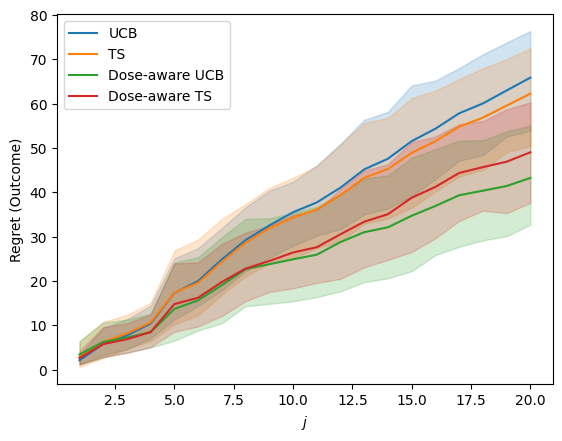

In [22]:
ax = SeriesOfSimulationsData.plot_lines(
    [s["result"] for s in calculated_series],
    [
        MaximizingCumulativeRegret(),
    ],
    legend_position=(1,1),
    process_df = rename_df,
)
plt.ylabel('Regret (Outcome)')
seaborn.move_legend(ax, "upper left", title=None)
plt.savefig("mt_resources/6-covariates/02_regret_outcome.pdf", bbox_inches="tight")

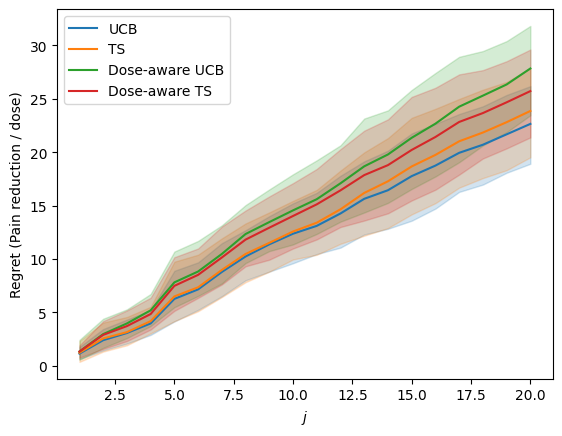

In [23]:
ax = SeriesOfSimulationsData.plot_lines(
    [s["result"] for s in calculated_series],
    [
        MaximizingCumulativeRegret(outcome_name = "reduction_per_dose"),
    ],
    process_df = rename_df,
)
plt.ylabel('Regret (Pain reduction / dose)')
seaborn.move_legend(ax, "upper left", title=None)
plt.savefig("mt_resources/6-covariates/02_reduction_per_dose.pdf", bbox_inches="tight")